# Trabalho 2 - SVD e recomendação de filmes.         Nícolas Hecker Silva         RA: 186132

A primeira parte importante desse trabalho é baixar as dependencias necessárias usando pip, caso a máquina não as possua. Para isso usamos o código abaixo:

In [28]:
# instalar dependencias
!python -m pip install pandas
!python -m pip install jax
!python -m pip install --upgrade "jax[cuda12_pip]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
!python -m pip install scikit-learn
!python -m pip install matplotlib


/usr/lib/python3.12/pty.py:95: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html


# Implementação do SVD:

Um passo importante para a realização desse trabalho, é a implementação da própria função do SVD. Para isso vamos primeiro criar uma pequena matriz teste e comparar as implementações nativas do numpy e do jax.

In [29]:
import jax.numpy as jnp

matrix = jnp.array([[1, 2, 3], [4, 5, 6], [7, 8, 9], [10, 11, 12]])

U, S, VT = jnp.linalg.svd(matrix, full_matrices=True)

print("Autovetores U:\n", U)
print("Autovalores:\n",S)
print("Autovetores VT:\n",VT)

print("\n================================== Agora com numpy ===========================================\n")
import numpy as np
matriz = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9], [10, 11, 12]])
Un, Sn, VTn = np.linalg.svd(matriz, full_matrices=True)

print("Autovetores U:\n", Un)
print("Autovalores:\n",Sn)
print("Autovetores VT:\n",VTn)


Autovetores U:
 [[ 0.14087664  0.82471395  0.46999776  0.2812515 ]
 [ 0.34394628  0.42626432 -0.8362956  -0.02468661]
 [ 0.5470158   0.02781341  0.2625992  -0.7943813 ]
 [ 0.75008535 -0.37063694  0.10369895  0.5378164 ]]
Autovalores:
 [2.5462400e+01 1.2906601e+00 2.8028271e-07]
Autovetores VT:
 [[ 0.5045332   0.5745157   0.64449817]
 [-0.7607754  -0.05714092  0.64649487]
 [ 0.40824872 -0.81649655  0.40824792]]

================================== Agora com numpy ===========================================

Autovetores U:
 [[-0.14087668 -0.82471435  0.54704904 -0.02715407]
 [-0.34394629 -0.42626394 -0.70915928  0.4439517 ]
 [-0.54701591 -0.02781353 -0.22282857 -0.80644121]
 [-0.75008553  0.37063688  0.38493881  0.38964357]]
Autovalores:
 [2.54624074e+01 1.29066168e+00 1.80972823e-15]
Autovetores VT:
 [[-0.50453315 -0.5745157  -0.64449826]
 [ 0.76077568  0.05714052 -0.64649464]
 [-0.40824829  0.81649658 -0.40824829]]


Aqui podemos ver que mesmo com as implementações nativas das duas bibliotecas, os valores obtidos não são os mesmos. Primeiro porque há diferenças nos sinais (positivos e negativos) dos autovetores de U e V. Segundo que há uma diferença por erro numérico dos dois métodos. Isso pode acontecer, dentre fatores como implmentações distintas, por conta das casas decimais do float utilizadas pelo processador e pela GPU, uma vez que o jax está a utilizando. Por fim, há ainda a diferença causada por conta dos autovalores serem nulos, o que faz com que os autovetores que os multiplicarão, não possuam valores relevantes, assumindo valores distintos para ambas as implementações, como os elementos 0.4699 da primeira matriz e o seu correspondente 0.5470 na segunda matriz. Dessa forma, é possível esperar que os métodos construídos, possuam uma precisão semelhante a esses dois métodos apresentados a cima.

Para implementar o SVD, o primeiro passo é encontrar as matrizes quadradas da esquerda e da direirta (SL e SR). Para isso, multiplicamos respectivamente a matriz original por sua transposta; e posteriormente a transposta pela matriz original. Após isso, utilizamos a função de obtenção dos autovalores e autovetores implementada pela biblioteca, uma vez que para resolver essa tarefa seria necessário implementar soluções de sistemas lineares, determinantes e outras ferramentas que não são o foco desse trabalho.

Após obter os autovalores s1 e s2 e os autovetores u e v, respectivamente obtidos das matrizes SL e SR, realizamos uma aproximação para 0 dos autovalores para todos os valores que possuírem módulo menor que 10⁻⁵. Assim podemos comparar diretamente os dois vetores de autovalores e verificar que, relevando os erros numéricos, eles são os mesmos. 

In [30]:
SL = matrix @ matrix.T
SR = matrix.T @ matrix

print("Matriz esquerda:\n",SL)
print("Matriz direita:\n",SR)
    
s1,u = jnp.linalg.eigh(SL)
s2,v = jnp.linalg.eigh(SR)

# se módulo menor que 1e-5, considera zero. Também tira a raiz quadrada
s1 = jnp.where(jnp.abs(s1) < 1e-5, 0, s1)**0.5
s2 = jnp.where(jnp.abs(s2) < 1e-5, 0, s2)**0.5

print("Autovetores esquerda:\n",u)
print("Autovetores direita:\n",v)
print("Autovalores S1:\n",s1)
print("Autovalores S2:\n",s2)

Matriz esquerda:
 [[ 14  32  50  68]
 [ 32  77 122 167]
 [ 50 122 194 266]
 [ 68 167 266 365]]
Matriz direita:
 [[166 188 210]
 [188 214 240]
 [210 240 270]]
Autovetores esquerda:
 [[-0.34394345  0.42626652  0.82471424  0.14087665]
 [ 0.14087537 -0.8247139   0.42626527  0.34394637]
 [ 0.7500866   0.37063494  0.02781123  0.5470159 ]
 [-0.5470166   0.02781428 -0.37063578  0.7500856 ]]
Autovetores direita:
 [[ 0.40824673 -0.7607764   0.50453305]
 [-0.8164966  -0.05713892  0.5745157 ]
 [ 0.4082495   0.6464938   0.6444983 ]]
Autovalores S1:
 [ 0.         0.         1.2906629 25.46241  ]
Autovalores S2:
 [ 0.         1.2906607 25.462406 ]


Embora os valores se s1 e s2 sejam os mesmos, ambos estão ordenados de forma descrescente, ou coicidentemente ordenados. Como é necessário utilizar os autovetores de forma crescente, vamos encontrar a ordenação que torna os autovalores crescentes e aplica-las as matrizes u e v.

Será também comparado com a implementação nativa do svd para a mesma matriz.

In [31]:
# obtem os indices para que ordenam os autovalores
idx1 = jnp.argsort(s1)[::-1]
idx2 = jnp.argsort(s2)[::-1]

# ordena os autovalores e autovetores
s1 = s1[idx1]
s2 = s2[idx2]

u = u[:,idx1]
v = v[:,idx2]

print("Autovetores esquerda ordenados:\n",u)
print("Autovetores direita ordenados transposto:\n",v.T)
print("Autovalores S1 ordenados:\n",s1)
print("Autovalores S2 ordenados:\n",s2)

print("\n ==================== comapração com SVD nativo =====================\n")

print("Autovetores U:\n", U)
print("Autovalores:\n",jnp.where(jnp.abs(S) < 1e-5, 0, S))
print("Autovetores VT:\n",VT)



Autovetores esquerda ordenados:
 [[ 0.14087665  0.82471424  0.42626652 -0.34394345]
 [ 0.34394637  0.42626527 -0.8247139   0.14087537]
 [ 0.5470159   0.02781123  0.37063494  0.7500866 ]
 [ 0.7500856  -0.37063578  0.02781428 -0.5470166 ]]
Autovetores direita ordenados transposto:
 [[ 0.50453305  0.5745157   0.6444983 ]
 [-0.7607764  -0.05713892  0.6464938 ]
 [ 0.40824673 -0.8164966   0.4082495 ]]
Autovalores S1 ordenados:
 [25.46241    1.2906629  0.         0.       ]
Autovalores S2 ordenados:
 [25.462406   1.2906607  0.       ]

 ==================== comapração com SVD nativo =====================

Autovetores U:
 [[ 0.14087664  0.82471395  0.46999776  0.2812515 ]
 [ 0.34394628  0.42626432 -0.8362956  -0.02468661]
 [ 0.5470158   0.02781341  0.2625992  -0.7943813 ]
 [ 0.75008535 -0.37063694  0.10369895  0.5378164 ]]
Autovalores:
 [25.4624     1.2906601  0.       ]
Autovetores VT:
 [[ 0.5045332   0.5745157   0.64449817]
 [-0.7607754  -0.05714092  0.64649487]
 [ 0.40824872 -0.81649655  0.

Aqui podemos verificar que os autovetores e autovalores estão iguais no mesmo nível que os métodos do jax e numpy estavam: com erros numéricos; Os sinais estão iguais; com autovetores aleatórios onde os autovalores são nulos.

Dessa forma podemos constrir a nossa função de SVD.

In [32]:
def svd(matrix):
    SL = matrix @ matrix.T
    SR = matrix.T @ matrix

    s1,u = jnp.linalg.eigh(SL)
    s2,v = jnp.linalg.eigh(SR)

    # se módulo menor que 1e-5, considera zero. Também tira a raiz quadrada
    s1 = jnp.where(jnp.abs(s1) < 1e-5, 0, s1)**0.5
    s2 = jnp.where(jnp.abs(s2) < 1e-5, 0, s2)**0.5

    # obtem os indices para que ordenam os autovalores
    idx1 = jnp.argsort(s1)[::-1]
    idx2 = jnp.argsort(s2)[::-1]

    # ordena os autovalores e autovetores
    s1 = s1[idx1]
    s2 = s2[idx2]

    u = u[:,idx1]
    v = v[:,idx2]

    return u,s1,v.T

u, s, vt = svd(matrix)
print("Autovetores U:\n", u)
print("Autovalores:\n",s)
print("Autovetores VT:\n",vt)

print("\n================================== Última comparação com o oficial ===========================================\n")

print("Autovetores U:\n", U)
print("Autovalores:\n",jnp.where(jnp.abs(S) < 1e-5, 0, S))
print("Autovetores VT:\n",VT)

Autovetores U:
 [[ 0.14087665  0.82471424  0.42626652 -0.34394345]
 [ 0.34394637  0.42626527 -0.8247139   0.14087537]
 [ 0.5470159   0.02781123  0.37063494  0.7500866 ]
 [ 0.7500856  -0.37063578  0.02781428 -0.5470166 ]]
Autovalores:
 [25.46241    1.2906629  0.         0.       ]
Autovetores VT:
 [[ 0.50453305  0.5745157   0.6444983 ]
 [-0.7607764  -0.05713892  0.6464938 ]
 [ 0.40824673 -0.8164966   0.4082495 ]]

================================== Última comparação com o oficial ===========================================

Autovetores U:
 [[ 0.14087664  0.82471395  0.46999776  0.2812515 ]
 [ 0.34394628  0.42626432 -0.8362956  -0.02468661]
 [ 0.5470158   0.02781341  0.2625992  -0.7943813 ]
 [ 0.75008535 -0.37063694  0.10369895  0.5378164 ]]
Autovalores:
 [25.4624     1.2906601  0.       ]
Autovetores VT:
 [[ 0.5045332   0.5745157   0.64449817]
 [-0.7607754  -0.05714092  0.64649487]
 [ 0.40824872 -0.81649655  0.40824792]]


Com os valores novamente comparados e a implementação do SVD correta, podemos seguir para os dados que serão utilizados nesse trabalho.

# Dataset

Para obter o dataset, realizamos uma requisição com wget e montamos a estrutura de pastas utilizando o unzip. Esse processamento apenas será realizado uma vez, para evitar gastos de recursos desnecessariamente. Para isso será verificado a estrutura de pastas construída.

In [33]:
# get the dataset of https://files.grouplens.org/datasets/movielens/ml-100k.zip if not exists
import os
if not os.path.exists('dataset-t2/ml-100k'):
    !wget https://files.grouplens.org/datasets/movielens/ml-100k.zip
    !unzip ml-100k.zip -d dataset-t2/
    # remove the zip file
    !rm ml-100k.zip

Vamos utilizar os dados completos no arquivo u.data. A estrutura é explicada no README desse dataset.

In [34]:
# carrega com pandas o dataset u1 separado por tabs
import pandas as pd

# carrega o dataset de avaliações
complete = pd.read_csv('dataset-t2/ml-100k/u.data', sep='\t', header=None)
complete.columns = ['user_id', 'movie_id', 'rating', 'timestamp']

complete_array = complete.pivot(index='user_id', columns='movie_id', values='rating').fillna(0).values

print(complete.info())

print(complete_array.shape)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   user_id    100000 non-null  int64
 1   movie_id   100000 non-null  int64
 2   rating     100000 non-null  int64
 3   timestamp  100000 non-null  int64
dtypes: int64(4)
memory usage: 3.1 MB
None
(943, 1682)


Podemos verificar que nesse arquivos há diversas avaliações maracadas pelo usuário que está avaliando, o filme avaliado e a nota dada. Há também a informação do instante de avaliação, que pode ser útil para criar um ID padronizado para as avaliações, mas que aqui será ignorado.

Esse dataset possui 100 000 amostras, com 1682 filmes e 943 avaliadores.

O próximo passo é realizar um particionamento entre treino e teste com as avaliações. É importante ressaltar que, como a reconstrução será feita com o SVD, é necessário que os pontos reconstruídos possuam filmes avaliados para servir de base para a reconstrução. Dessa forma, não será possível dividir com base nos avaliadores, reconstruindo totalmente os seus chutes, pois dessa forma não haveria dados base para a reconstrução.

A divisão proposta é de 20% de teste e 80% de treino, o que corresponde exatamente a divisão feita pelos autores nas partições disponibilizadas. Assim, será utilizado oarquivo u2.teste, como o conjunto de teste. O conjunto de treino será contruído removendo pontos do dataset completo que estão presentes no conjunto de teste.

Por fim o conjunto de teste será construído através da matriz completa subtraída da matriz de treino. Isso precisa ser feito pois a construção direta das matrizes pelos dados acaba excluindo linhas vazias, o que acaba criando matrizes de dimensões menores que a original, o que dificulta a comparação.

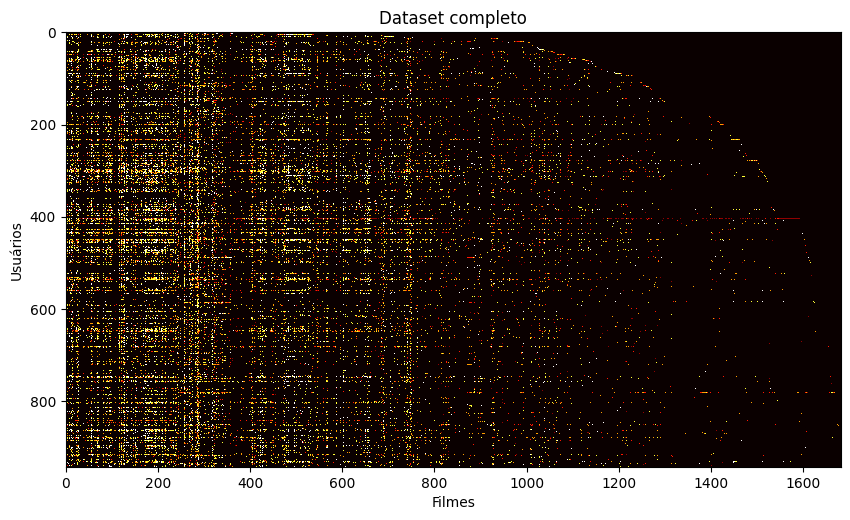

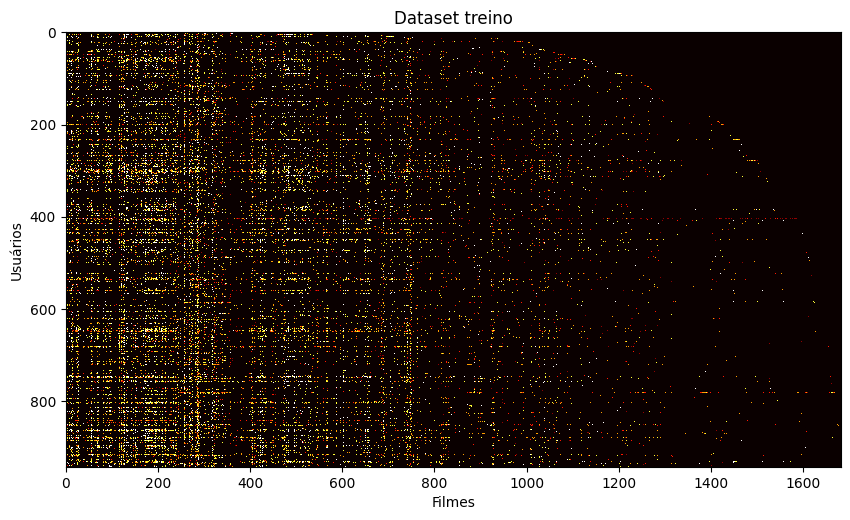

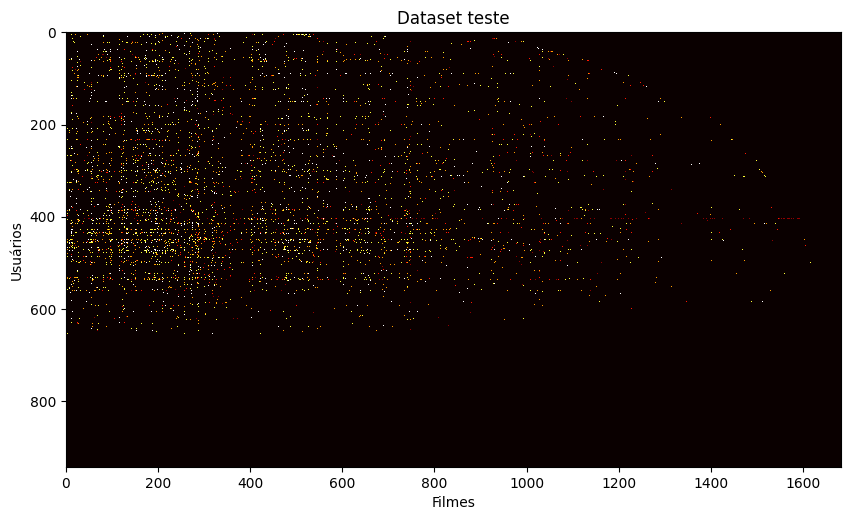

In [35]:
# carrega o dataset de avaliações particionado em 20 80 u1
u1_test_raw = pd.read_csv('dataset-t2/ml-100k/u2.test', sep='\t', header=None)
u1_test_raw.columns = ['user_id', 'movie_id', 'rating', 'timestamp']

train_array = complete_array.copy()

# mostra o dataset completo
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
plt.title('Dataset completo')
plt.imshow(train_array, cmap='hot', interpolation='nearest')
plt.xlabel('Filmes')
plt.ylabel('Usuários')
plt.show()

# remove os valores de teste do dataset completo
for index, row in u1_test_raw.iterrows():
    train_array[row['user_id']-1,row['movie_id']-1] = 0

plt.figure(figsize=(10,10))
plt.title("Dataset treino")
plt.xlabel('Filmes')
plt.ylabel('Usuários')
plt.imshow(train_array, cmap='hot', interpolation='nearest')
plt.show()

# mostra a subtração dos dois datasets
test_array = complete_array - train_array
plt.figure(figsize=(10,10))
plt.title("Dataset teste")
plt.xlabel('Filmes')
plt.ylabel('Usuários')
plt.imshow(test_array, cmap='hot', interpolation='nearest')
plt.show()




Podemos ver algumas características interessantes dos dados. Primeiro, o dados são muito esparços, tendo grandes regiões vazias. Segundo, há um formato curioso no conjunto de treino nas laterais, o que deve ter acontecido por conta da forma como os dados foram ordenados, com os avaliadores sendo organizados com base no maior ID de filme que ele avaliou, o que cria a região vazia superior direita. É possível ver também que os dados de teste da partição 2 não contém avaliações dos indivíduos acima de 700.

Algumas características intessantes é a de que há linhas orizontais vermelhas, o que significa avaliadores muito crítivos, enquanto há linhas horizontais amarelas, o que significa avaliadores pouco críticos. É visível tambpem linhas amarelas, o que indica filmes populares e bem avaliados, mas não há linhas verticais vermelhas, uma vez que filmes mal avaliados normalmente não são populares e não são vistos por todos para serem avaliados.

Vamos tentar agora realizar a reconstrução das matrizes utilizando a svd nativo e verificar se ela é igual a matriz original calculando também seu erro.

(943, 943) (943,) (943, 1682)


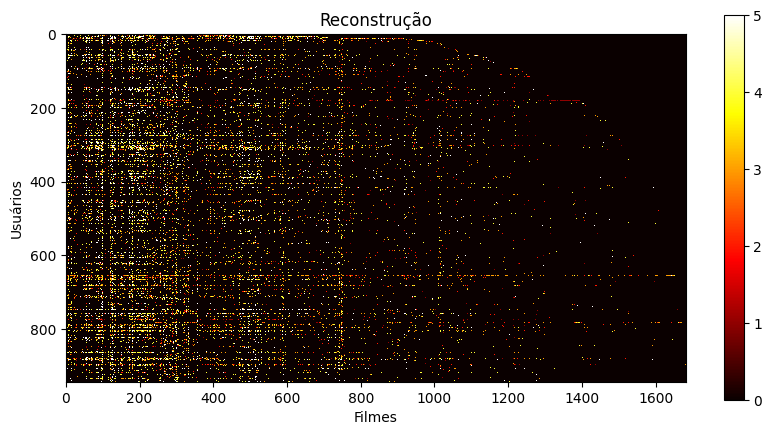

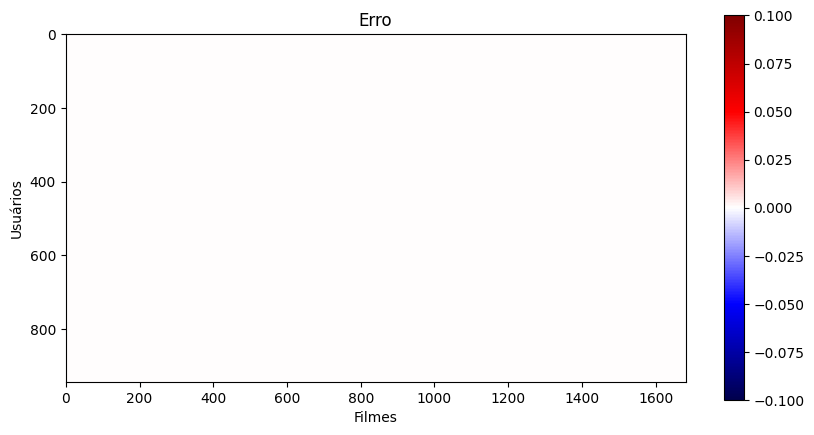

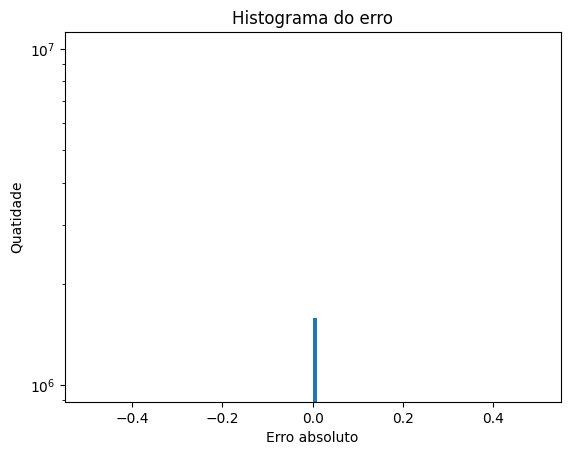

[-0.]


In [36]:
# calcula a SVD da matriz de treino
U, S, VT = jnp.linalg.svd(train_array, full_matrices=False)
print(U.shape, S.shape, VT.shape)

# tenta reconstruir a matriz original
reconstructed = U @ jnp.diag(S) @ VT

# mostra o reconstructed
plt.figure(figsize=(10, 5))
plt.title("Reconstrução")
plt.xlabel('Filmes')
plt.ylabel('Usuários')
plt.imshow(reconstructed, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

erro = train_array - reconstructed

# aproxima os valores para o inteiro mais próximo (para ignorar erros numericos)
erro = jnp.round(erro)

# mostra o erro
plt.figure(figsize=(10, 5))
plt.title("Erro")
plt.xlabel('Filmes')
plt.ylabel('Usuários')
plt.imshow(erro, cmap='seismic', interpolation='nearest')
plt.colorbar()
plt.show()

# mostra o erro como histograma
plt.hist(erro.flatten(), bins=100)
plt.title("Histograma do erro")
# escala log
plt.yscale('log')
plt.xlabel('Erro absoluto')
plt.ylabel('Quatidade')
plt.show()

# mostra os erros (unicos)
print(jnp.unique(erro))


Podemos verificar que a reconstrução foi um sucesso. Vamos agora aplicar a função própria e ver o resultado

(943, 943) (943,) (1682, 1682)


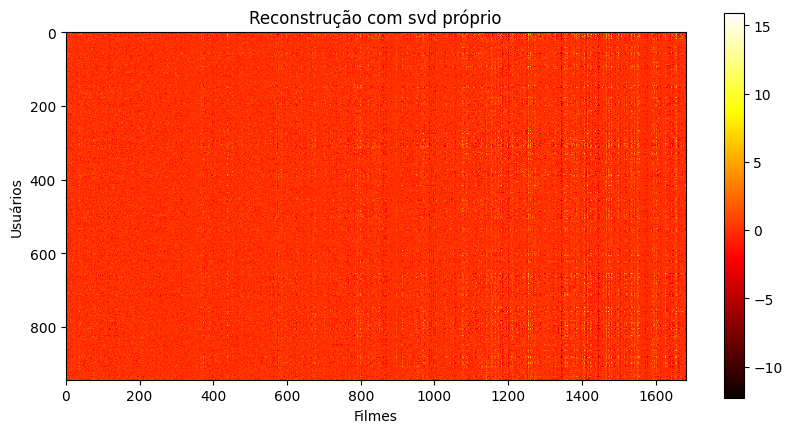

In [37]:
u, s, vT = svd(train_array)
print(u.shape, s.shape, vT.shape)

# tenta reconstruir a matriz original
reconstructed = u @ jnp.diag(s) @ vT[:u.shape[0],:]

# mostra o reconstructed
plt.figure(figsize=(10, 5))
plt.title("Reconstrução com svd próprio")
plt.xlabel('Filmes')
plt.ylabel('Usuários')
plt.imshow(reconstructed, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()



A matriz reconstruída foi completamente diferente da original, o que indica um erro grave na implementação.

Vamos construir uma outra implementação do SVD utilizando um caminho diferente.

In [38]:
def svd_2_0(a):
    nlinhas, ncolunas = a.shape

    if nlinhas >= ncolunas:
        SR = jnp.dot(a.T, a)
        eigenvalues, v = jnp.linalg.eigh(SR)
    else:
        SL = jnp.dot(a, a.T)
        eigenvalues, u = jnp.linalg.eigh(SL)

    # Ordena de forma decrescente
    idx = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[idx]

    # Raiz quadrada
    s = jnp.sqrt(eigenvalues)


    # calcula o u e v com base em v e u, dependendo do tamanho da matriz
    if nlinhas >= ncolunas:
        v = v[:, idx]
        u = jnp.dot(a, v) / s
    else:
        u = u[:, idx]
        v = jnp.dot(a.T, u) / s

    return u, s, v.T

Aqui o SVD foi construído com base no número de linhas e colunas da matriz. Os valores são calculados de forma semelhante a antes, mas com a diferença que se a matriz possuir mais linhas que colunas, o valor de u é calculado com base nos valores encontrados de v e s, enquanto que se o numero de colunas for maior, o valor de v é calculado com base nos valores de u e s.

Vamos ver o resultado agora.

(943, 943) (943,) (943, 1682)


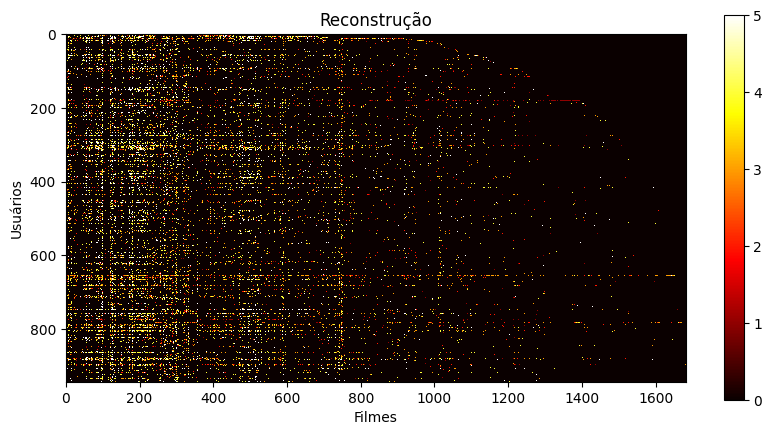

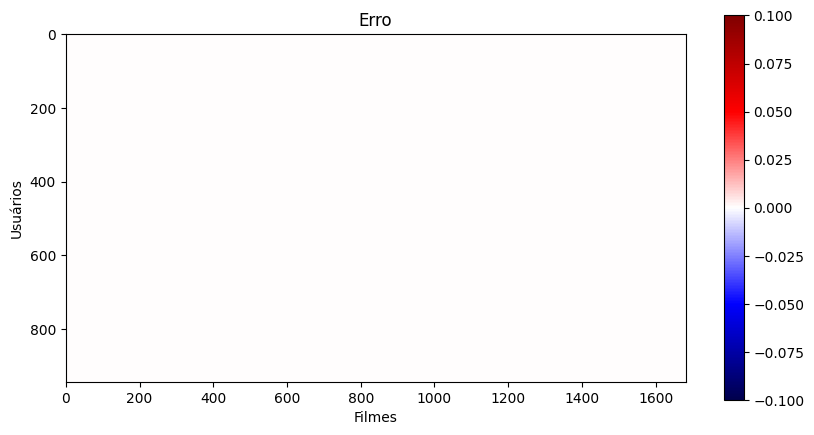

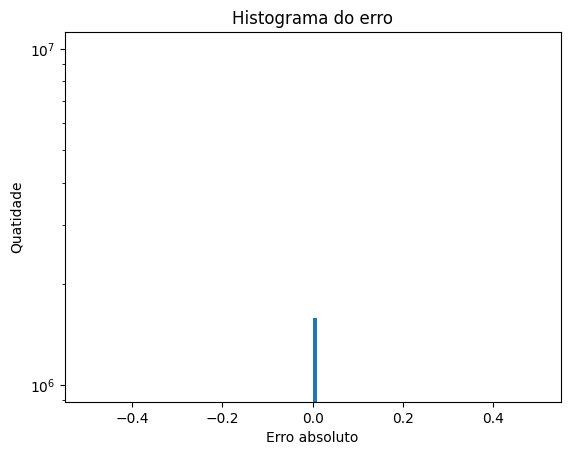

[-0.]


In [39]:
# calcula a SVD da matriz de treino
U, S, VT = svd_2_0(train_array)
print(U.shape, S.shape, VT.shape)

# tenta reconstruir a matriz original
reconstructed = U @ jnp.diag(S) @ VT

# mostra o reconstructed
plt.figure(figsize=(10, 5))
plt.title("Reconstrução")
plt.xlabel('Filmes')
plt.ylabel('Usuários')
plt.imshow(reconstructed, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

erro = train_array - reconstructed

# aproxima os valores para o inteiro mais próximo (para ignorar erros numericos)
erro = jnp.round(erro)

# mostra o erro
plt.figure(figsize=(10, 5))
plt.title("Erro")
plt.xlabel('Filmes')
plt.ylabel('Usuários')
plt.imshow(erro, cmap='seismic', interpolation='nearest')
plt.colorbar()
plt.show()

# mostra o erro como histograma
plt.hist(erro.flatten(), bins=100)
plt.title("Histograma do erro")
# escala log
plt.yscale('log')
plt.xlabel('Erro absoluto')
plt.ylabel('Quatidade')
plt.show()

# mostra os erros (unicos)
print(jnp.unique(erro))


Dessa vez o erro foi nulo, indicando que a nossa implementação está correta.

Vamos ver como está a capacidade da reconstrução de prever o resultado.

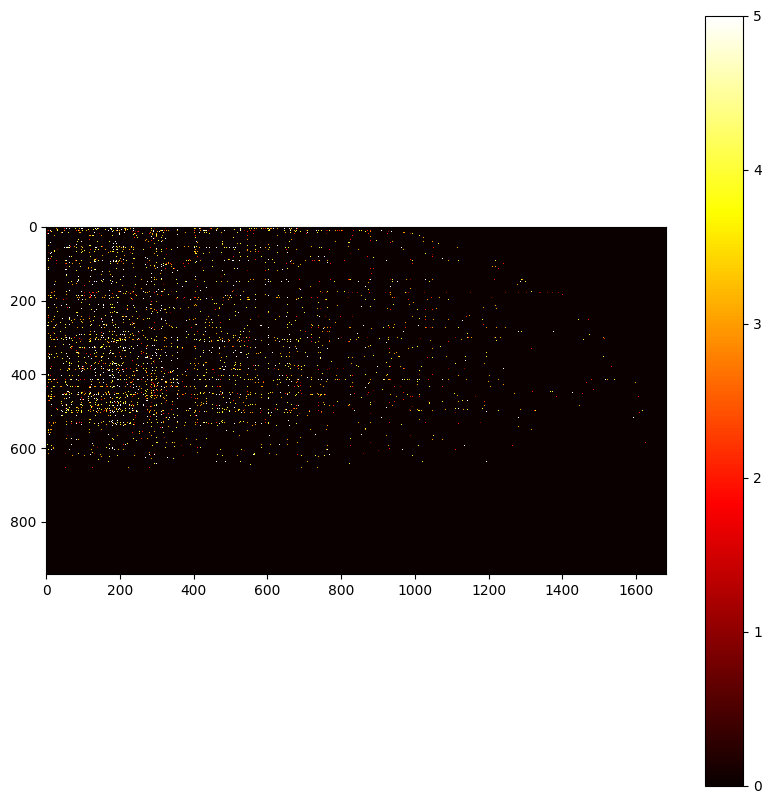

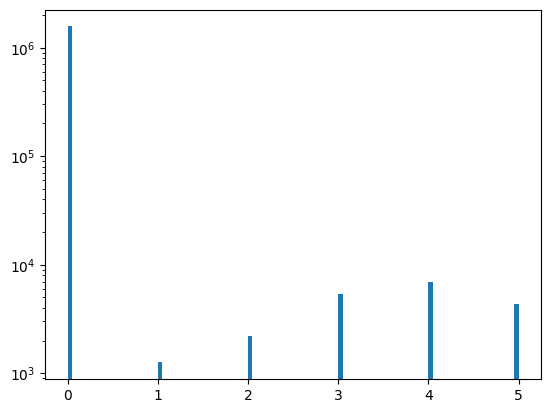

[0. 1. 2. 3. 4. 5.]


In [42]:
erro = complete_array - reconstructed

# aproxima os valores para o inteiro mais próximo (para ignorar erros numericos)
erro = jnp.round(erro)

# mostra o erro
plt.figure(figsize=(10, 10))
plt.imshow(erro, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

# mostra o erro como histograma
plt.hist(erro.flatten(), bins=100)
# escala log
plt.yscale('log')
plt.show()

# mostra os erros (unicos)
print(jnp.unique(erro))


Como esperado, a matriz original subtraída da matriz reconstruída resultadou exatamente na matriz de teste, uma vez que a reconstrução perfeita acaba por produzir valores nulos para todos os pontos de teste no dataset. Assim os erros existem apenas nesses pontos e é zero onde não há dados de teste.

## Visualizando os autovetores e autovalores

Vamos aogra ver o resultado dos autovalores encontrados. Eles significam a importância de cada autovetor para reconstruir a matriz original.

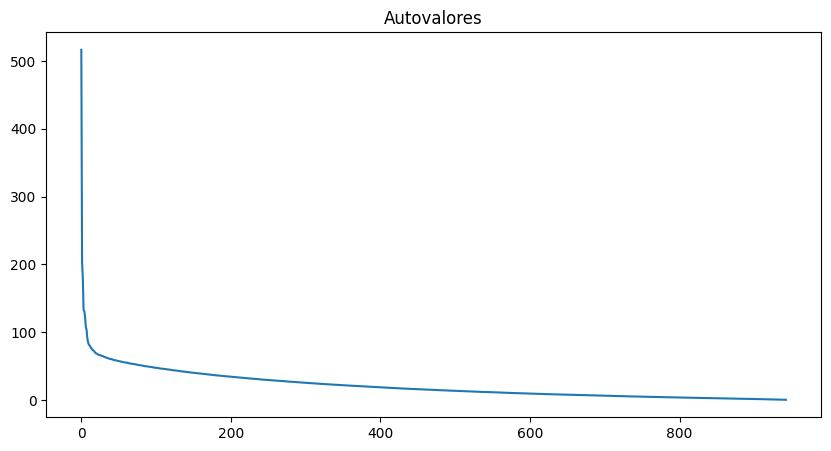

In [14]:
# plota os autovalores S
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(S)
plt.title("Autovalores")
plt.show()

Desse gráfico verficiamos que a maior importância é dada pelos primeiros 20 autovalores, mas ainda há autovalores consideráveis até próximo do 800, o que indica uma dependencia forte de todos os vetores para construir todas as relações entre os filmes e os avaliadores. O que indica um problema complexo.

Como o gráfico acima possui valores muito altos no começo, é mais difícil ver o comportamento para valores mais baixos. Para isso vamos mostrar o mesmo gráfico mas com escala logarítimica.

Text(0.5, 1.0, 'Autovalores')

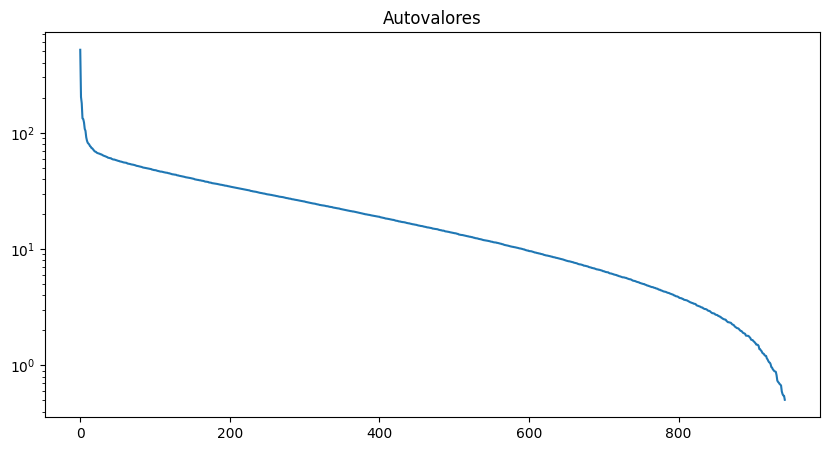

In [15]:
# plota novamente em escala loagaritmica
plt.figure(figsize=(10,5))
plt.plot(S)
plt.yscale('log')
plt.title("Autovalores")

Agora a partir desse gráfico, podemos ver que apenas a partir de 900 os autovalores passam a ser desprezíveis. Entreranto um corte em 800 cortaria apenas autovalroes menores que 10, o que pode trazer uma redução aceitável.

Text(0.5, 1.0, 'Autovalores')

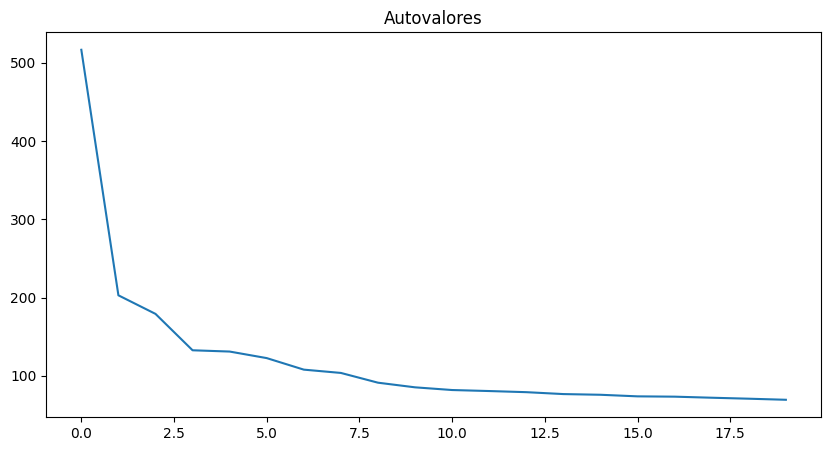

In [16]:
# plota novamente em escala loagaritmica
plt.figure(figsize=(10,5))
plt.plot(S[:20])
plt.title("Autovalores")

Tendo mostrado os primeiros 20 valores, é possível verificar que mesmo entre eles, há uma influencia enorme dos primeiros 3 autovalores, com os próximos contribuido muito menos.

Vejamos agora os autovetores. Para desenha-los utilizaremos primeiro o mapa de calor, depois um zoom no começo e depois verificaremos o primeiro autovetor.

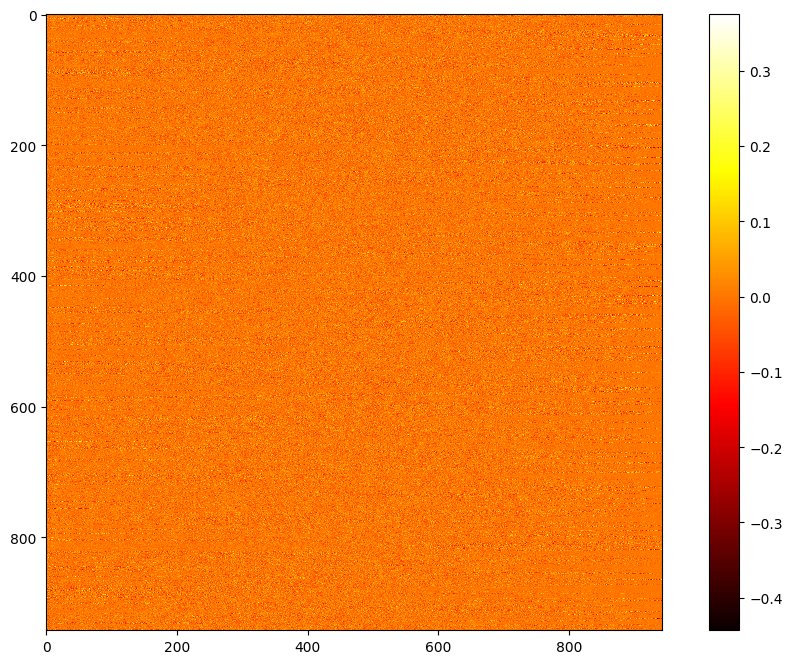

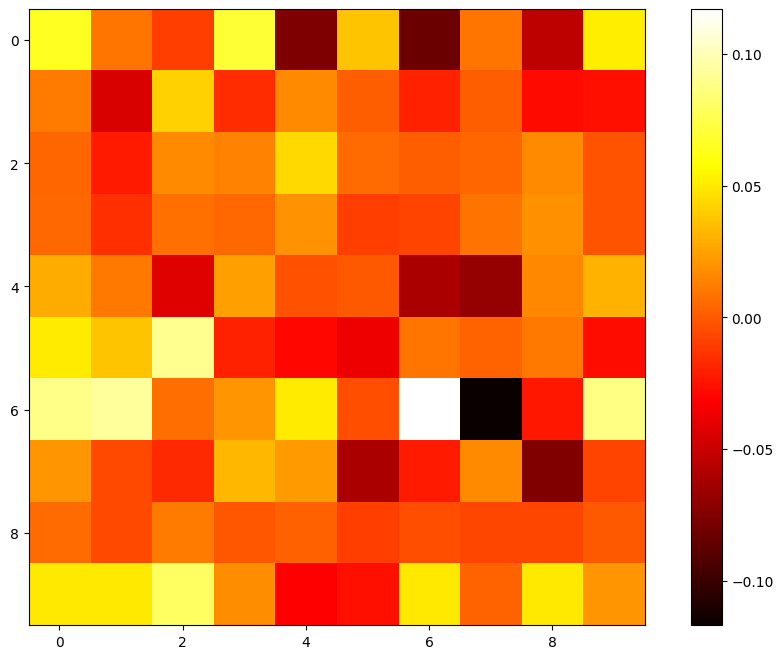

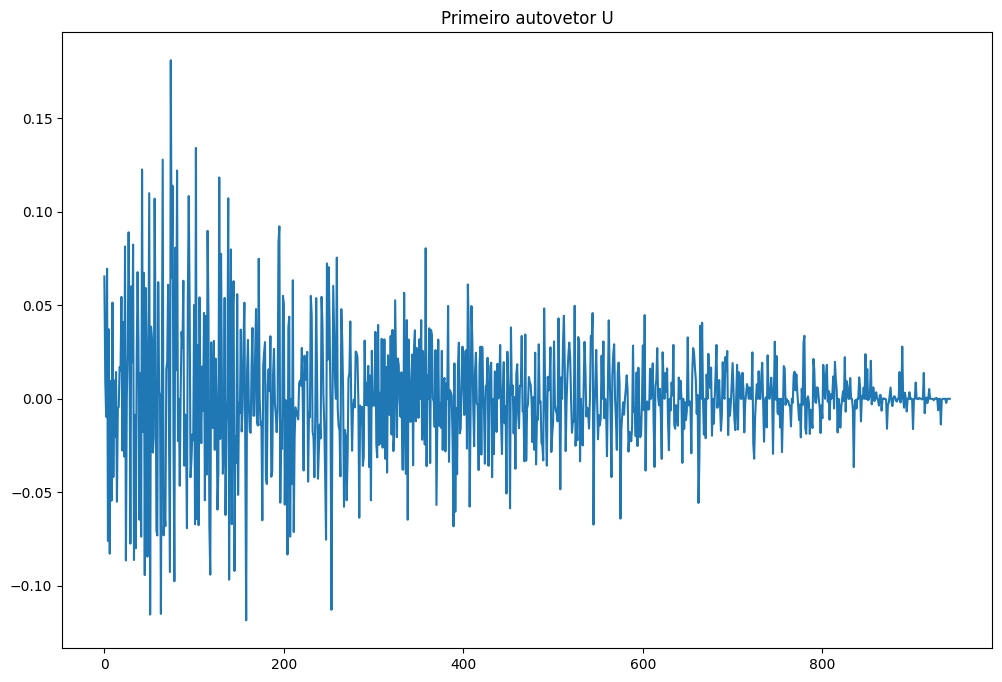

In [17]:
# mostra um mapa de calor dos autovetores U
plt.figure(figsize=(12, 8))
plt.imshow(U, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

# mostra um mapa de calor dos autovalores U recortado
plt.figure(figsize=(12, 8))
plt.imshow(U[:10,:10], cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

plt.figure(figsize=(12, 8))
plt.plot(U[0])
plt.title("Primeiro autovetor U")
plt.show()



Aqui podemos verificar que o intervalo de variação dos autovetores de U variam em torno de 0 com um desvio máximo de 0.5 ou semelhante. Há muitos valores próximos a 0 tornando a visualização complexa. Entretanto é possível verificar que há diversas variações nessa matriz quadrada, que podem ser melhor vizualizadas plotando os 10 primeiros valores como um zoom.

Ali é possível ver algumas possíveis relações entre usuários. Como há um ponto muito claro na linha 6 com coluna 6, mas um ponto muito escuro com o ponto na mesma linha e coluna 7, podemos inferir uma discordancia nas avaliações entre os avaliadores 6 e 7, o que pode indicar que eles gostam de filmes distintos. Pos sua vez, para esse pedaço, os usuários 2 e 3, possuem linhas muito próximas, o que pode indicar uma concordância entre os gostos de filmes. Entretanto, ao olhar para as colunas essas análises se tornam diferentes, sendo difícil inferir informações puramente palos autovetores.

Olhando para o autovetor mais relevante, vemos que ele possui valores altos próximo ao avaliador 100, mas valores menores conforme o ID do avaliador aumenta. Isso pode estar indicando Uma indiferença entre as avaliações do usuário com o pico positivo com relação aos de pico de módulo baixo. Ao mesmo tempo, vemos que há valores muito baixos ao redor do avaliador 200, o que indicam que usuários com pico positivo, normamente não gostam de filmes que os avaliadores de pico negativo gostam, o que pode indicar não só gêneros de filmes diferentes, mas também possivelmente gêneros opostos, como algum filme traquilo de romance ou comédia e um filme de terror.


Agora vamos olhar para os autovetores de V

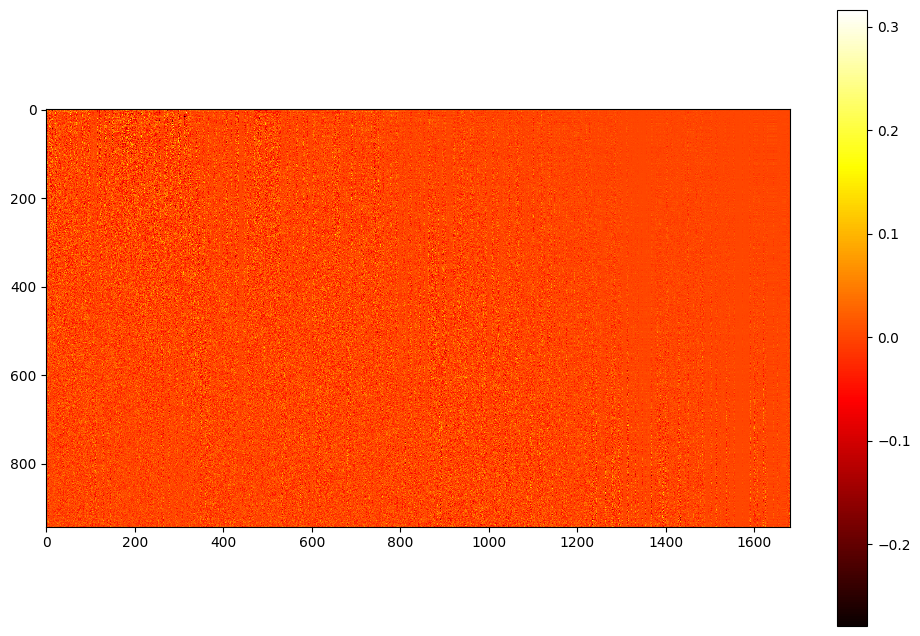

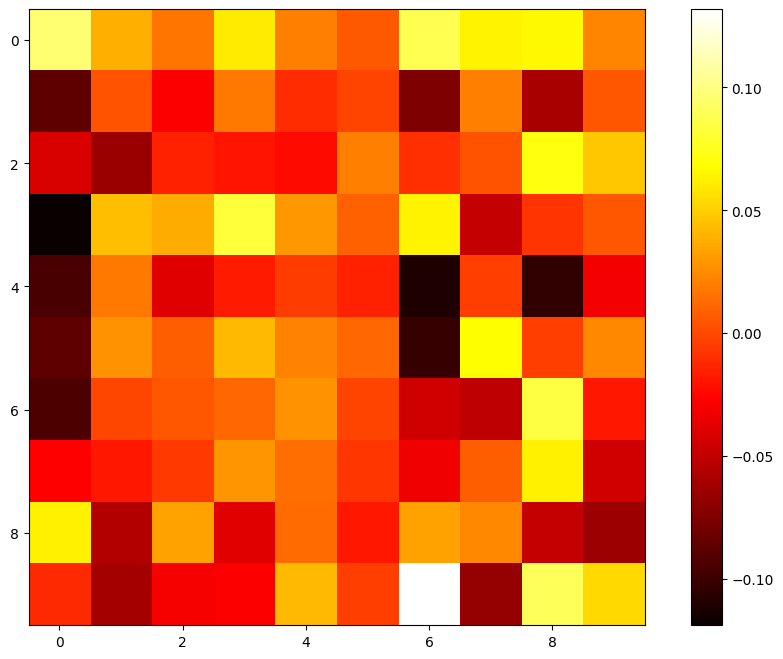

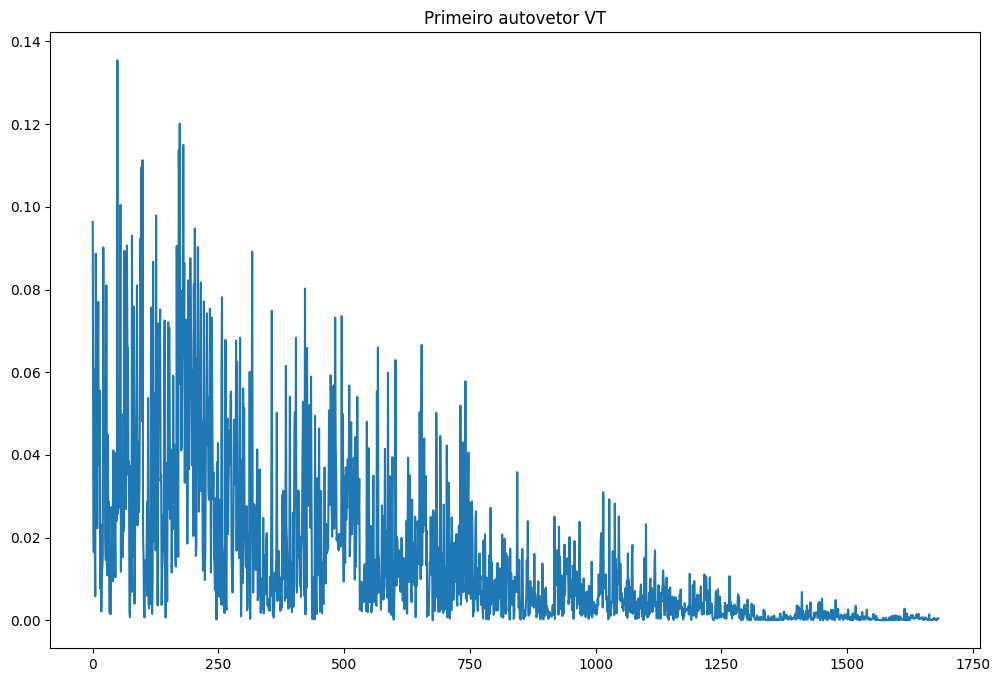

In [18]:
# mostra um mapa de calor dos autovetores VT
plt.figure(figsize=(12, 8))
plt.imshow(VT, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

# mostra um mapa de calor dos autovalores VT recortado
plt.figure(figsize=(12, 8))
plt.imshow(VT[:10,:10], cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

plt.figure(figsize=(12, 8))
plt.plot(VT[0])
plt.title("Primeiro autovetor VT")
plt.show()


Aqui vemos a relação entre as qualdiades dos filmes e possívelmente os seus gêneros, com a relação entre os filmes caindo conforme o ID diminui. Isso também pode indicar que os filmes finais são menos bem avaliados, o que faz sentido com a distribuição dos dados que apresenta os primeiros filmes mais frequentemente vistos que os filmes com IDs maiores.

# Reconstrução com menos autovalores

Agora vamos tentar diminuir o número de autovalores para tentar realizar uma predição de valores faltantes.

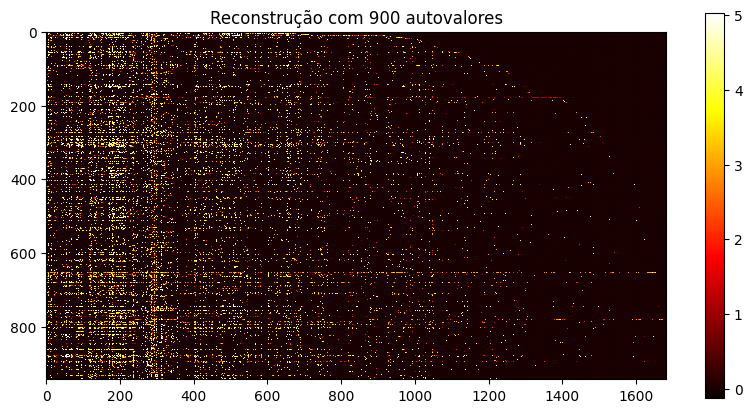

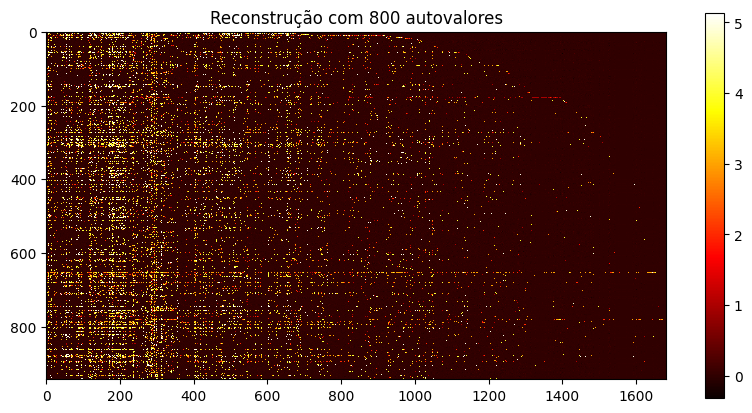

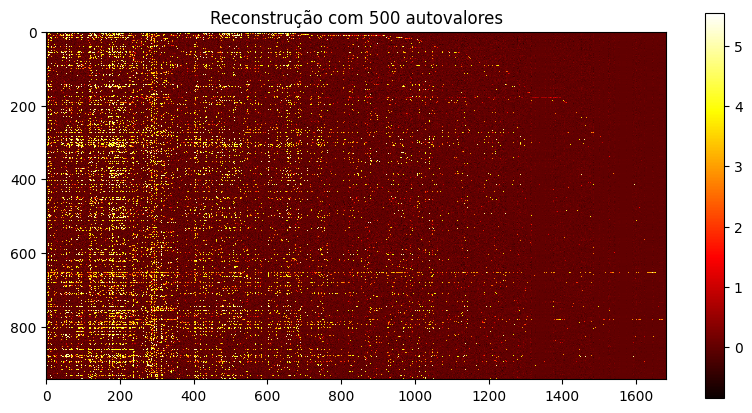

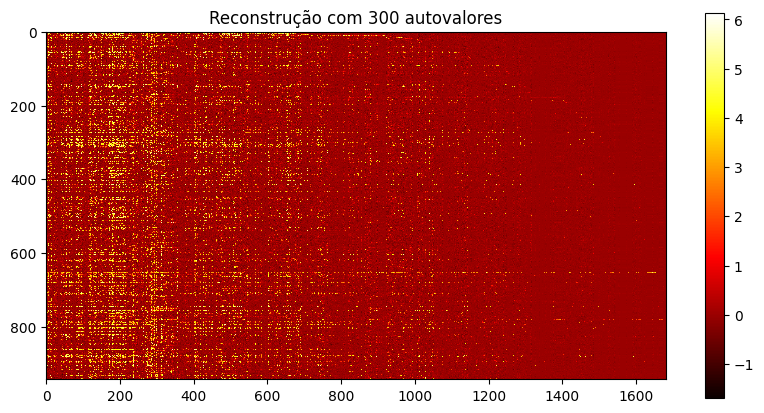

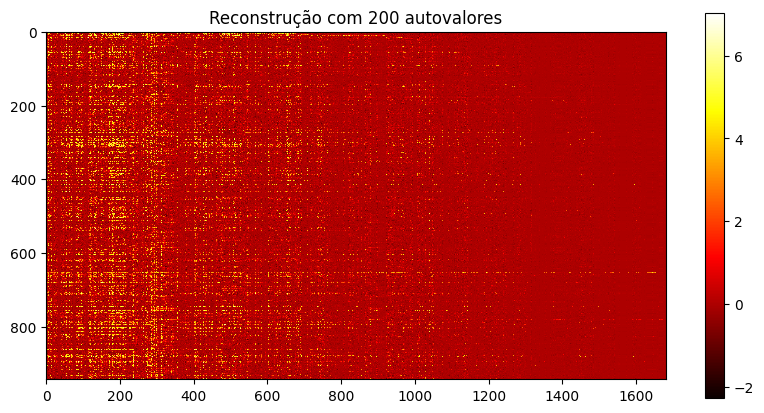

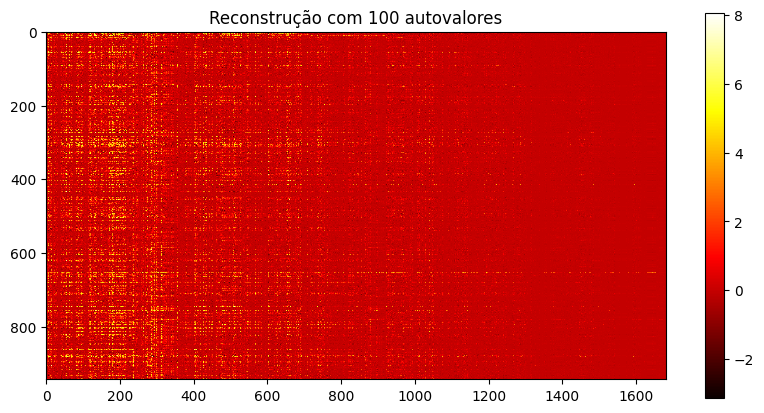

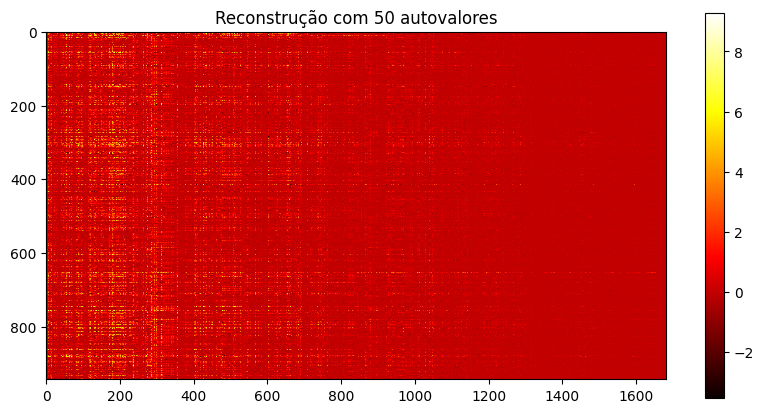

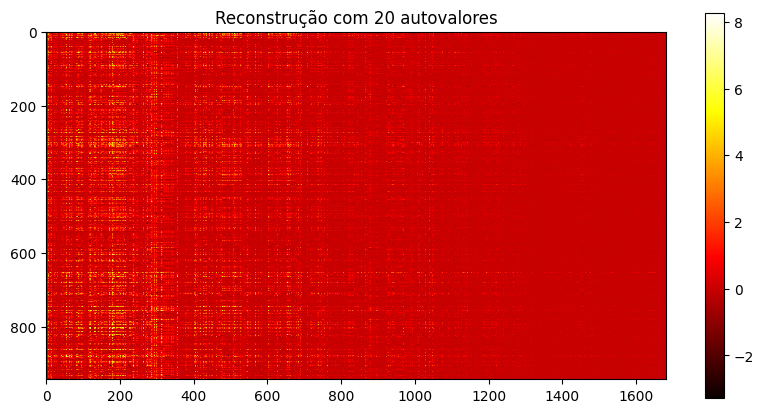

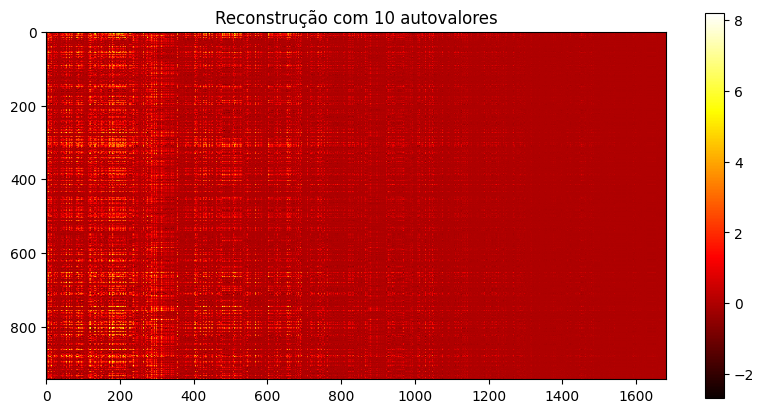

In [19]:
# testa diferetes valores de corte: 800, 500, 200, 100, 50, 20, 10
for corte in [900, 800, 500, 300, 200, 100, 50, 20, 10]:
    # S_10 é S com os primeiros autovalores, o resto é zero
    S_10 = np.zeros_like(S)
    S_10[:corte] = S[:corte]

    # reconstroi a matriz
    reconstructed_10 = U @ jnp.diag(S_10) @ VT

    # mostra a matriz reconstruida
    plt.figure(figsize=(10, 5))
    plt.imshow(reconstructed_10, cmap='hot', interpolation='nearest')
    plt.colorbar()
    plt.title(f"Reconstrução com {corte} autovalores")
    plt.show()

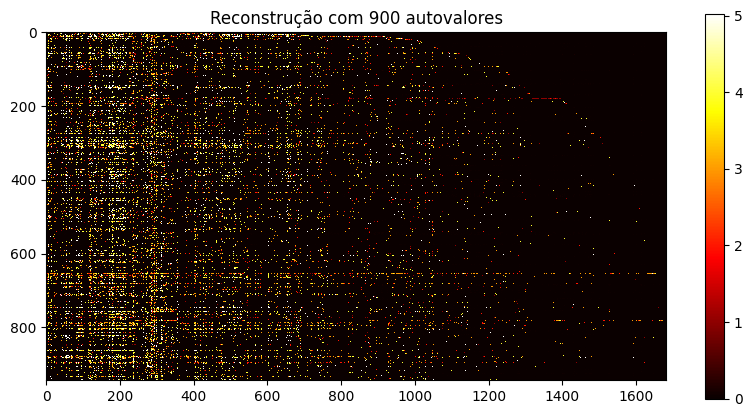

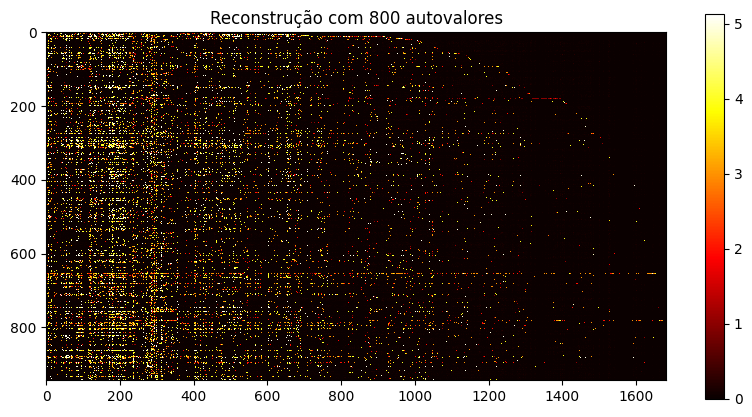

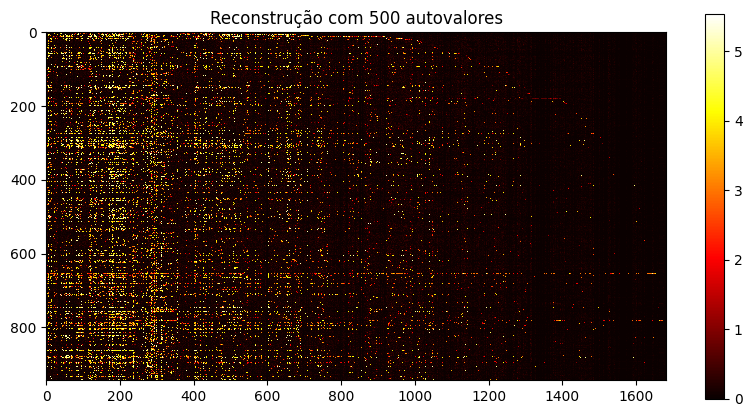

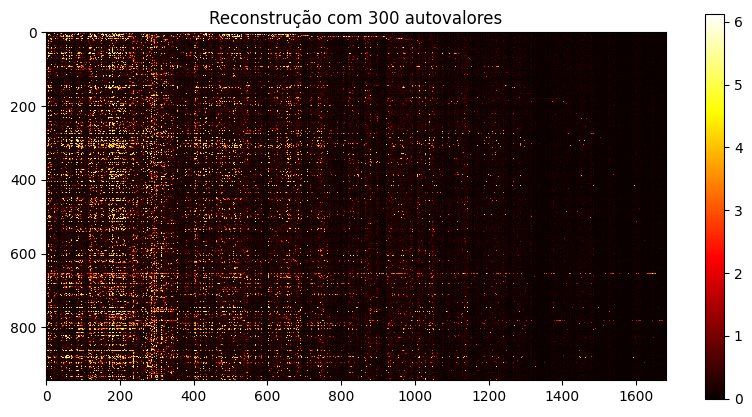

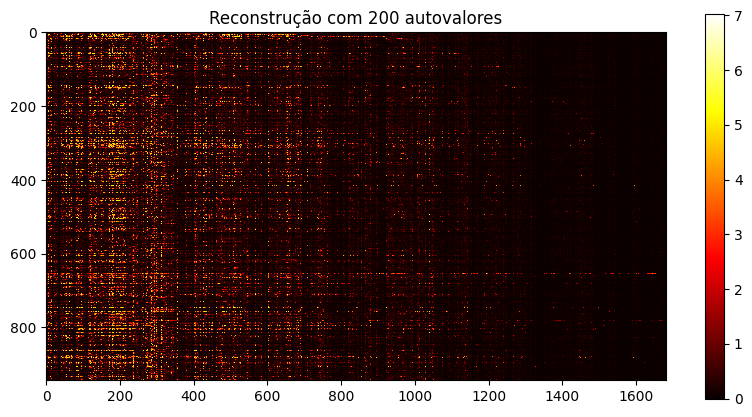

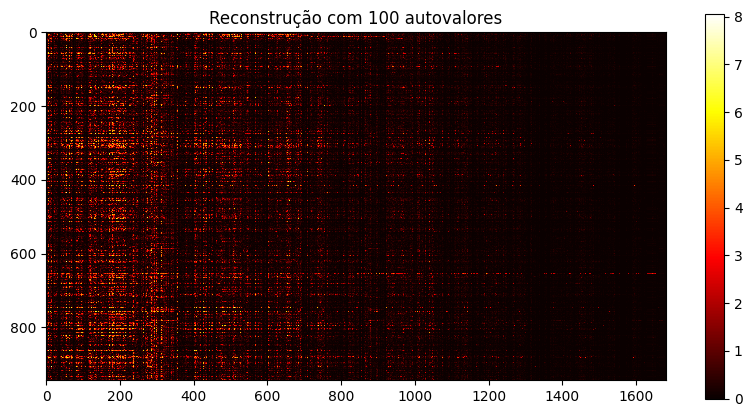

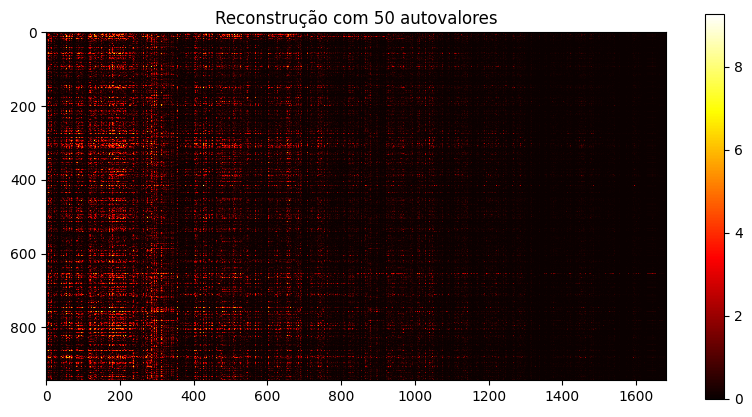

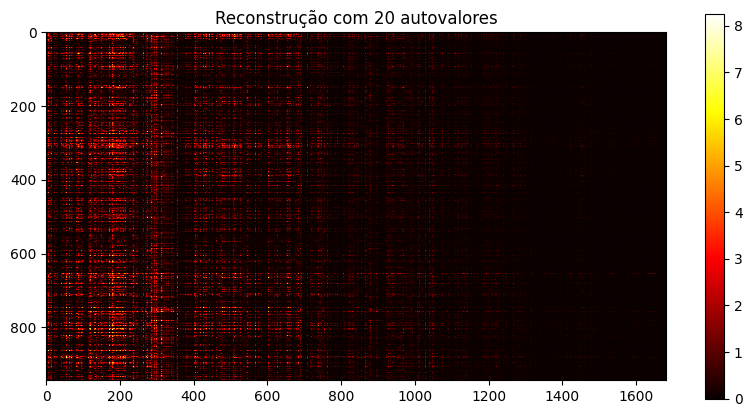

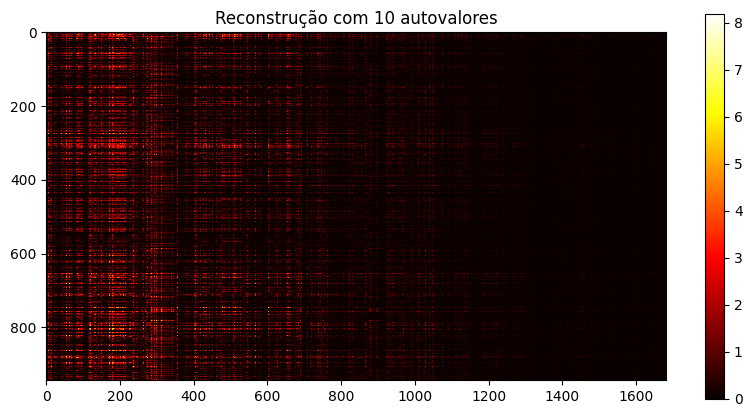

In [20]:
# testa diferetes valores de corte: 800, 500, 200, 100, 50, 20, 10
for corte in [900, 800, 500, 300, 200, 100, 50, 20, 10]:
    # S_10 é S com os primeiros autovalores, o resto é zero
    S_10 = np.zeros_like(S)
    S_10[:corte] = S[:corte]

    # reconstroi a matriz
    reconstructed_10 = jnp.abs(U @ jnp.diag(S_10) @ VT)

    # mostra a matriz reconstruida
    plt.figure(figsize=(10, 5))
    plt.imshow(reconstructed_10, cmap='hot', interpolation='nearest')
    plt.colorbar()
    plt.title(f"Reconstrução com {corte} autovalores")
    plt.show()

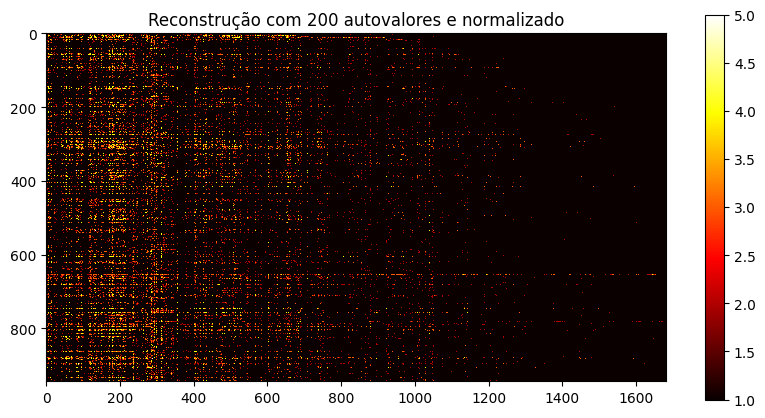

Há  1566126  zeros no dataset de teste
(Array([-4, -3, -2, -1,  0,  1], dtype=int32), Array([   3844,    6604,    5570,    2560, 1567475,      73], dtype=int32))
[[  -4   -3   -2   -1    0    1]
 [3844 6604 5570 2560 1349   73]]
A taxa de acerto foi de  6.7450004 %


In [21]:
# calculo da acuracia com 200 autovetores
S_200 = np.zeros_like(S)
S_200[:200] = S[:200]

reconstructed_20 = jnp.abs(U @ jnp.diag(S_200) @ VT)

# normaliza min max para 1 e 5

reconstructed_20 = 1 + (reconstructed_20 - reconstructed_20.min()) / (reconstructed_20.max() - reconstructed_20.min()) * 4

#arredonda para o inteiro mais próximo
reconstructed_20 = jnp.round(reconstructed_20)

# mostra a matriz reconstruida
plt.figure(figsize=(10, 5))
plt.imshow(reconstructed_20, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title(f"Reconstrução com 200 autovalores e normalizado")
plt.show()

# compara com o dataset de teste

just_test_mask = test_array > 0

sub = reconstructed_20*just_test_mask-test_array

# numero de 0s no dataset de teste
n_zeros_teste = jnp.sum(just_test_mask)
n_zeros_teste = just_test_mask.size - n_zeros_teste
print("Há ", n_zeros_teste, " zeros no dataset de teste")

# vetor das ocorrencias em diferencas
ocorrencias = jnp.unique(jnp.round(sub).astype(int).flatten(), return_counts=True)

print(ocorrencias)


# obtem a posicao do 0 em ocorrencias
i = 0
for i, x in enumerate(ocorrencias[0]):
    if x == 0:
        break

# subtrai os valores de 0

ocorrencias = np.array(ocorrencias)

ocorrencias[1][i] -= n_zeros_teste


ocorrencias = jnp.array(ocorrencias)

print(ocorrencias)

print("A taxa de acerto foi de ", ocorrencias[1][i]/jnp.sum(ocorrencias[1])*100, "%")


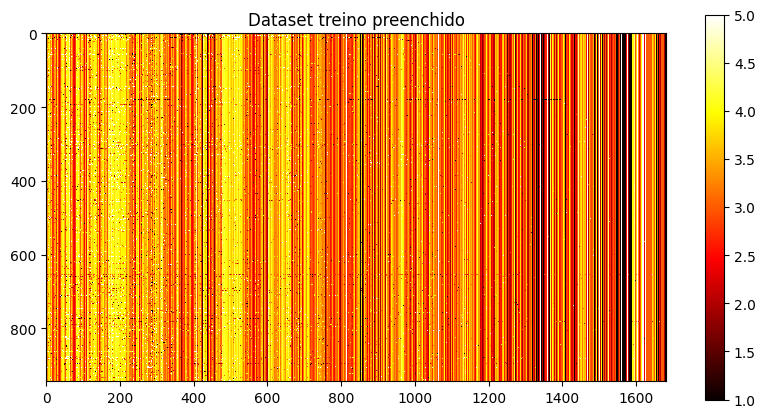

In [22]:
# preencge o treino com a mediana por coluna onde é zero
train_array_filled_vertical = train_array.copy()
train_array_filled_vertical[train_array_filled_vertical == 0] = jnp.nan
train_array_filled_vertical = jnp.where(jnp.isnan(train_array_filled_vertical), jnp.nanmean(train_array_filled_vertical, axis=0), train_array_filled_vertical)

# mostra o dataset treino preenchido
plt.figure(figsize=(10,5))
plt.title("Dataset treino preenchido")
plt.imshow(train_array_filled_vertical, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

Por algum motivo isso aqui trava

In [23]:
# Uv, Sv, VTv = jnp.linalg.svd(train_array_filled_vertical, full_matrices=False)

(943, 1682)


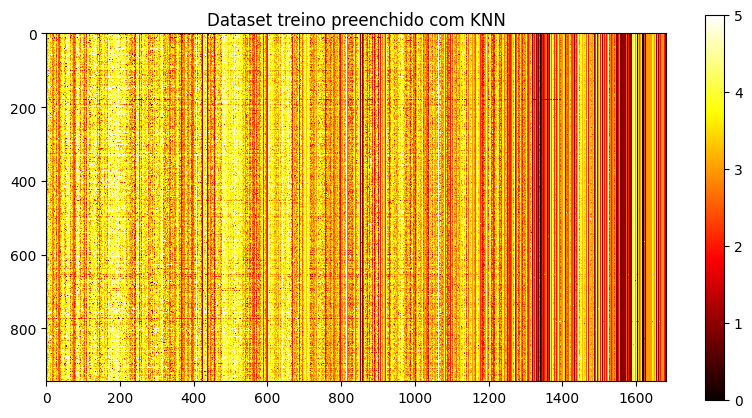

(943, 1682)


In [24]:
# completa os 0s usando knn

from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=5, missing_values=0, keep_empty_features=True)

print(train_array.shape)
train_array_filled_knn = imputer.fit_transform(train_array)



# mostra o dataset treino preenchido
plt.figure(figsize=(10,5))
plt.title("Dataset treino preenchido com KNN")
plt.imshow(train_array_filled_knn, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

print(train_array_filled_knn.shape)

(943, 1682)
(943, 1682)


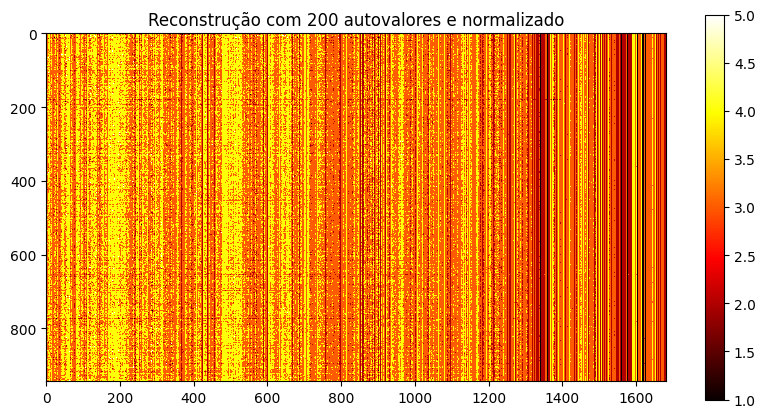

Há  1566126  zeros no dataset de teste
(Array([-3, -2, -1,  0,  1,  2,  3], dtype=int32), Array([     29,    1119,    6205, 1573589,    3659,    1324,     201],      dtype=int32))
[[  -3   -2   -1    0    1    2    3]
 [  29 1119 6205 7463 3659 1324  201]]
A taxa de acerto foi de  37.315002 %


In [25]:
print(train_array_filled_knn.shape)

Uk, Sk, VTk = jnp.linalg.svd(train_array_filled_knn, full_matrices=False)

# reconstroi com 200 autovalores

Sk_200 = np.zeros_like(Sk)
Sk_200[:200] = Sk[:200]

reconstructed_knn_200 = jnp.abs(Uk @ jnp.diag(Sk_200) @ VTk)

print(reconstructed_knn_200.shape)

# normaliza min max para 1 e 5

reconstructed_knn_200 = 1 + (reconstructed_knn_200 - reconstructed_knn_200.min()) / (reconstructed_knn_200.max() - reconstructed_knn_200.min()) * 4

#arredonda para o inteiro mais próximo

reconstructed_knn_200 = jnp.round(reconstructed_knn_200)

# mostra a matriz reconstruida

plt.figure(figsize=(10, 5))
plt.imshow(reconstructed_knn_200, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title(f"Reconstrução com 200 autovalores e normalizado")
plt.show()

# compara com o dataset de teste

just_test_mask = test_array > 0

sub = reconstructed_knn_200*just_test_mask-test_array

# numero de 0s no dataset de teste
n_zeros_teste = jnp.sum(just_test_mask)
n_zeros_teste = just_test_mask.size - n_zeros_teste
print("Há ", n_zeros_teste, " zeros no dataset de teste")

# vetor das ocorrencias em diferencas
ocorrencias = jnp.unique(jnp.round(sub).astype(int).flatten(), return_counts=True)

print(ocorrencias)

# obtem a posicao do 0 em ocorrencias
i = 0
for i, x in enumerate(ocorrencias[0]):
    if x == 0:
        break

# subtrai os valores de 0

ocorrencias = np.array(ocorrencias)

ocorrencias[1][i] -= n_zeros_teste


ocorrencias = jnp.array(ocorrencias)

print(ocorrencias)

print("A taxa de acerto foi de ", ocorrencias[1][i]/jnp.sum(ocorrencias[1])*100, "%")



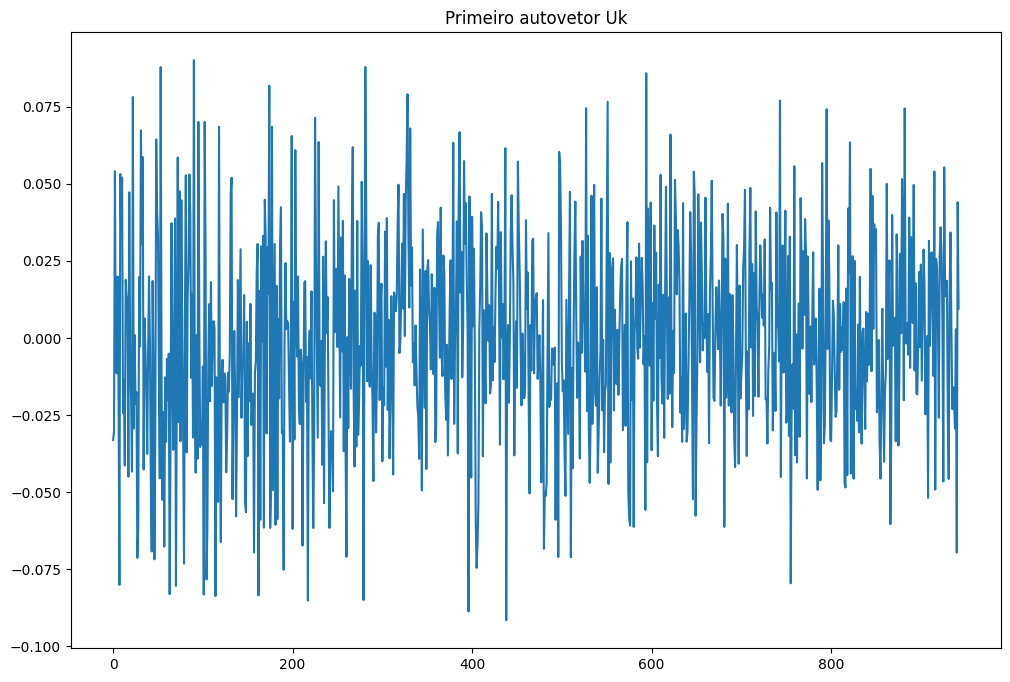

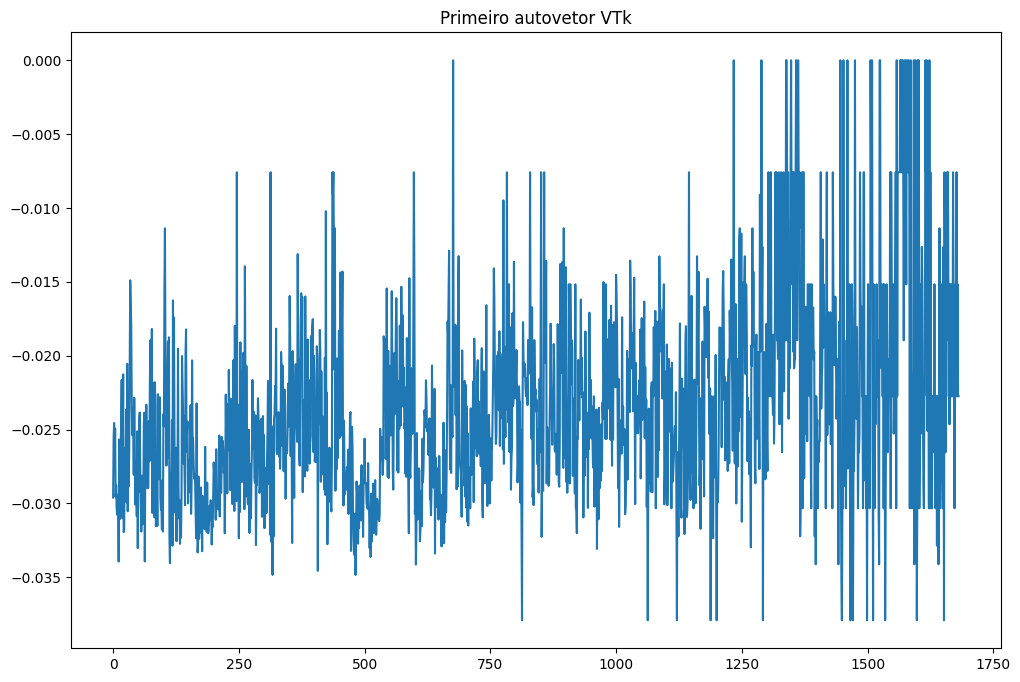

In [26]:
# mostra a primeira linha de U e VT

plt.figure(figsize=(12, 8))
plt.plot(Uk[0])
plt.title("Primeiro autovetor Uk")
plt.show()

plt.figure(figsize=(12, 8))
plt.plot(VTk[0])
plt.title("Primeiro autovetor VTk")
plt.show()


Conclusão